## Splink deduplication demo 

In this demo we de-duplicate a small dataset.

The purpose is to provide an end-to-end example of how to use the package

I print the output at each stage using `spark_dataframe.show()`.  This is for instructional purposes only - it degrades performance and shouldn't be used in a production setting.

## Step 1:  Imports and setup

The following is just boilerplate code that sets up the Spark session and sets some other non-essential configuration options

In [1]:
import pandas as pd 
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

In [2]:
import logging 
logging.basicConfig()  # Means logs will print in Jupyter Lab

# Set to DEBUG if you want splink to log the SQL statements it's executing under the hood
logging.getLogger("splink").setLevel(logging.INFO)

In [3]:
from utility_functions.demo_utils import get_spark
spark = get_spark() # See utility_functions/demo_utils.py for how to set up Spark

## Step 2:  Read in data

In [4]:
df = spark.read.parquet("data/fake_1000.parquet")
df.show(5)

+---------+----------+-------+----------+------+--------------------+-----+
|unique_id|first_name|surname|       dob|  city|               email|group|
+---------+----------+-------+----------+------+--------------------+-----+
|        0|    Julia |   null|2015-10-29|London| hannah88@powers.com|    0|
|        1|    Julia | Taylor|2015-07-31|London| hannah88@powers.com|    0|
|        2|    Julia | Taylor|2016-01-27|London| hannah88@powers.com|    0|
|        3|    Julia | Taylor|2015-10-29|  null|  hannah88opowersc@m|    0|
|        4|      oNah| Watson|2008-03-23|Bolton|matthew78@ballard...|    1|
+---------+----------+-------+----------+------+--------------------+-----+
only showing top 5 rows



## Step 3:  Configure splink using the `settings` object

Most of `splink` configuration options are stored in a settings dictionary.  This dictionary allows significant customisation, and can therefore get quite complex.  

💥 We provide an tool for helping to author valid settings dictionaries, which includes tooltips and autocomplete, which you can find [here](http://robinlinacre.com/splink_settings_editor/).

Customisation overrides default values built into splink.  For the purposes of this demo, we will specify a simple settings dictionary, which means we will be relying on these sensible defaults.

To help with authoring and validation of the settings dictionary, we have written a [json schema](https://json-schema.org/), which can be found [here](https://github.com/moj-analytical-services/splink/blob/master/splink/files/settings_jsonschema.json).  




In [5]:
settings = {
    "link_type": "dedupe_only",
    "blocking_rules": [
        "l.first_name = r.first_name",
        "l.surname = r.surname",
        "l.dob = r.dob"
    ],
    "comparison_columns": [
        {
            "col_name": "first_name",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "surname",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "dob"
        },
        {
            "col_name": "city"
        },
        {
            "col_name": "email"
        }
    ],
    "additional_columns_to_retain": ["group"],
    "em_convergence": 0.01
}

In words, this setting dictionary says:
- We are performing a deduplication task (the other options are `link_only`, or `link_and_dedupe`)
- We are going generate comparisons subject to the blocking rules contained in the specified array
- When comparing records, we will use information from the `first_name`, `surname`, `dob`, `city` and `email` columns to compute a match score.
- For `first_name` and `surname`, string comparisons will have three levels:
    - Level 2: Strings are (almost) exactly the same
    - Level 1: Strings are similar 
    - Level 0: No match
- We will make adjustments for term frequencies on the `first_name` and `surname` columns
- We will retain the `group` column in the results even though this is not used as part of comparisons.  This is a labelled dataset and `group` contains the true match - i.e. where group matches, the records pertain to the same person
- Consider the algorithm to have converged when no parameter changes by more than 0.01 between iterations

## Step 4:  Estimate match scores using the Expectation Maximisation algorithm
Columns are assumed to be strings by default.  See the 'comparison vector settings' notebook for details of configuration options.

In [6]:
from splink import Splink

linker = Splink(settings, spark, df=df)
df_e = linker.get_scored_comparisons()


INFO:splink.iterate:Iteration 0 complete
INFO:splink.params:The maximum change in parameters was 0.5087412834167481 for key π_gamma_surname_prob_dist_non_match_level_2_probability
INFO:splink.iterate:Iteration 1 complete
INFO:splink.params:The maximum change in parameters was 0.0954439640045166 for key π_gamma_surname_prob_dist_match_level_2_probability
INFO:splink.iterate:Iteration 2 complete
INFO:splink.params:The maximum change in parameters was 0.021286725997924805 for key π_gamma_dob_prob_dist_non_match_level_0_probability
INFO:splink.iterate:Iteration 3 complete
INFO:splink.params:The maximum change in parameters was 0.010865330696105957 for key π_gamma_dob_prob_dist_non_match_level_0_probability
INFO:splink.iterate:Iteration 4 complete
INFO:splink.params:The maximum change in parameters was 0.008596867322921753 for key π_gamma_email_prob_dist_match_level_0_probability
INFO:splink.iterate:EM algorithm has converged


## Step 5: Inspect results 



In [7]:
# Inspect main dataframe that contains the match scores
cols_to_inspect = ["match_probability","unique_id_l","unique_id_r","group_l", "group_r", "first_name_l","first_name_r","surname_l","surname_r","dob_l","dob_r","city_l","city_r","email_l","email_r",]

df_e.toPandas()[cols_to_inspect].sort_values(["unique_id_l", "unique_id_r"]).head(10)

,match_probability,unique_id_l,unique_id_r,group_l,group_r,first_name_l,first_name_r,surname_l,surname_r,dob_l,dob_r,city_l,city_r,email_l,email_r
2,0.985811,0,1,0,0,Julia,Julia,None,Taylor,2015-10-29,2015-07-31,London,London,hannah88@powers.com,hannah88@powers.com
1,0.985811,0,2,0,0,Julia,Julia,None,Taylor,2015-10-29,2016-01-27,London,London,hannah88@powers.com,hannah88@powers.com
0,0.999646,0,3,0,0,Julia,Julia,None,Taylor,2015-10-29,2015-10-29,London,None,hannah88@powers.com,hannah88opowersc@m
4,0.983115,1,2,0,0,Julia,Julia,Taylor,Taylor,2015-07-31,2016-01-27,London,London,hannah88@powers.com,hannah88@powers.com
3,0.916171,1,3,0,0,Julia,Julia,Taylor,Taylor,2015-07-31,2015-10-29,London,None,hannah88@powers.com,hannah88opowersc@m
2290,0.027342,1,89,0,18,Julia,Chirla,Taylor,Taylor,2015-07-31,2006-06-28,London,London,hannah88@powers.com,mbrooks@booker.com
2289,0.027342,1,142,0,26,Julia,Harry,Taylor,Taylor,2015-07-31,2017-11-24,London,London,hannah88@powers.com,coltonray@lee.com
2288,0.027342,1,148,0,26,Julia,Harry,Taylor,Taylor,2015-07-31,2017-09-01,London,London,hannah88@powers.com,coltonray@lee.com
4821,0.792436,1,246,0,43,Julia,Harrison,Taylor,Joshua,2015-07-31,2015-07-31,London,Southend-on-Sea,hannah88@powers.com,None
2287,0.039123,1,362,0,62,Julia,None,Taylor,Taylor,2015-07-31,1989-07-25,London,London,hannah88@powers.com,wagnershane@landry.com


In [8]:
df_e.toPandas()

,tf_adjusted_match_prob,match_probability,unique_id_l,unique_id_r,first_name_l,first_name_r,gamma_first_name,prob_gamma_first_name_non_match,prob_gamma_first_name_match,first_name_adj,surname_l,surname_r,gamma_surname,prob_gamma_surname_non_match,prob_gamma_surname_match,surname_adj,dob_l,dob_r,gamma_dob,prob_gamma_dob_non_match,prob_gamma_dob_match,city_l,city_r,gamma_city,prob_gamma_city_non_match,prob_gamma_city_match,email_l,email_r,gamma_email,prob_gamma_email_non_match,prob_gamma_email_match,group_l,group_r
0,0.999991,0.999646,0,3,Julia,Julia,2,0.472290,0.567037,0.975943,None,Taylor,-1,1.000000,1.000000,0.500000,2015-10-29,2015-10-29,1,0.031396,0.875362,London,None,-1,1.00000,1.000000,hannah88@powers.com,hannah88opowersc@m,1,0.007089,0.894782,0,0
1,0.999645,0.985811,0,2,Julia,Julia,2,0.472290,0.567037,0.975943,None,Taylor,-1,1.000000,1.000000,0.500000,2015-10-29,2016-01-27,0,0.968604,0.124638,London,London,1,0.14658,0.780896,hannah88@powers.com,hannah88@powers.com,1,0.007089,0.894782,0,0
2,0.999645,0.985811,0,1,Julia,Julia,2,0.472290,0.567037,0.975943,None,Taylor,-1,1.000000,1.000000,0.500000,2015-10-29,2015-07-31,0,0.968604,0.124638,London,London,1,0.14658,0.780896,hannah88@powers.com,hannah88@powers.com,1,0.007089,0.894782,0,0
3,0.988914,0.916171,1,3,Julia,Julia,2,0.472290,0.567037,0.975943,Taylor,Taylor,2,0.673685,0.564559,0.167495,2015-07-31,2015-10-29,0,0.968604,0.124638,London,None,-1,1.00000,1.000000,hannah88@powers.com,hannah88opowersc@m,1,0.007089,0.894782,0,0
4,0.997900,0.983115,1,2,Julia,Julia,2,0.472290,0.567037,0.975943,Taylor,Taylor,2,0.673685,0.564559,0.167495,2015-07-31,2016-01-27,0,0.968604,0.124638,London,London,1,0.14658,0.780896,hannah88@powers.com,hannah88@powers.com,1,0.007089,0.894782,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5706,0.999920,0.999920,984,985,Laal,None,-1,1.000000,1.000000,0.500000,Ball,None,-1,1.000000,1.000000,0.500000,1992-04-02,1992-04-02,1,0.031396,0.875362,Newcastle-upon-Tyne,Newcastle-upon-Tyne,1,0.14658,0.780896,stacykelly@brown.info,stacykelly@brown.info,1,0.007089,0.894782,176,176
5707,0.999884,0.999884,991,996,liL,Lily,0,0.526308,0.363365,0.500000,Young,None,-1,1.000000,1.000000,0.500000,1995-09-05,1995-09-05,1,0.031396,0.875362,London,London,1,0.14658,0.780896,wesleykidd@miller.com,wesleykidd@miller.com,1,0.007089,0.894782,179,179
5708,0.987535,0.987535,991,994,liL,Lily,0,0.526308,0.363365,0.500000,Young,Ynuo,0,0.326083,0.376637,0.500000,1995-09-05,1995-09-05,1,0.031396,0.875362,London,London,1,0.14658,0.780896,wesleykidd@miller.com,None,-1,1.000000,1.000000,179,179
5709,0.999998,0.999998,992,996,ily,Lily,1,0.001403,0.069598,0.500000,Young,None,-1,1.000000,1.000000,0.500000,1995-09-05,1995-09-05,1,0.031396,0.875362,London,London,1,0.14658,0.780896,wesleykidd@miller.com,wesleykidd@miller.com,1,0.007089,0.894782,179,179


The `params` property of the `linker` is an object that contains a lot of diagnostic information about how the match probability was computed.  The following cells demonstrate some of its functionality

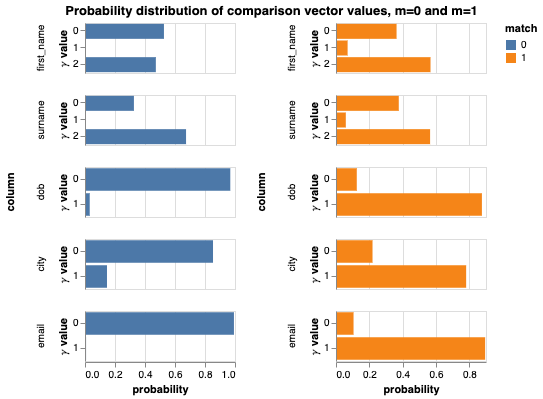

In [9]:
params = linker.params
params.probability_distribution_chart()

An alternative representation of the parameters displays them in terms of the effect different values in the comparison vectors have on the match probability:

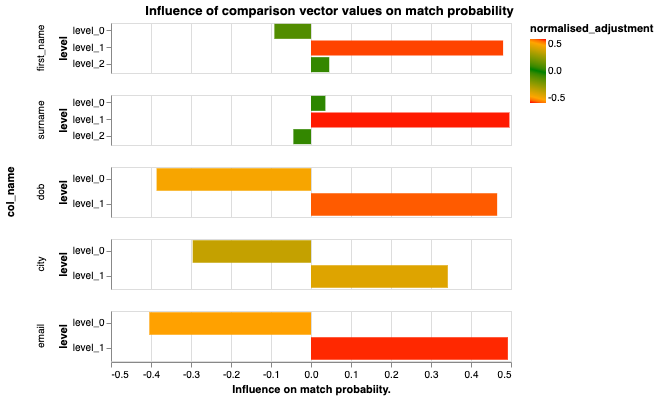

In [10]:
params.adjustment_factor_chart()

In [11]:
# If charts aren't displaying correctly in your notebook, you can write them to a file (by default splink_charts.html)
params.all_charts_write_html_file(filename="splink_charts.html", overwrite=True)

You can also generate a report which explains how the match probability was computed for an individual comparison row.  

Note that you need to convert the row to a dictionary for this to work

In [12]:
from splink.intuition import intuition_report
row_dict = df_e.toPandas().sample(1).to_dict(orient="records")[0]
print(intuition_report(row_dict, params))


Initial probability of match (prior) = λ = 0.4007764458656311

Comparison of first_name.  Values are:
first_name_l: Freddie 
first_name_r: Daniel 
Comparison has 3 levels
𝛾 for this comparison = gamma_first_name = 0
Amongst matches, P(𝛾 = 0.36336517333984375):
Amongst non matches, P(𝛾 = 0.5263075232505798):
Adjustment factor = p1/(p1 + p2) = 0.4084256769173678
New probability of match (updated belief): 0.3158935311624162

Comparison of surname.  Values are:
surname_l: Palmer
surname_r: Palmer
Comparison has 3 levels
𝛾 for this comparison = gamma_surname = 2
Amongst matches, P(𝛾 = 0.5645585060119629):
Amongst non matches, P(𝛾 = 0.6736847162246704):
Adjustment factor = p1/(p1 + p2) = 0.45593506661171407
New probability of match (updated belief): 0.27900016553109575

Comparison of dob.  Values are:
dob_l: 2008-08-10
dob_r: 2016-06-14
Comparison has 2 levels
𝛾 for this comparison = gamma_dob = 0
Amongst matches, P(𝛾 = 0.12463843822479248):
Amongst non matches, P(𝛾 = 0.9686039686203003):
A

# Use graphframes to resolve links into groups

In [18]:
from graphframes import GraphFrame


df_e.createOrReplaceTempView("df_e")
sql = """
select unique_id_l as id
from df_e
union
select unique_id_r as id
from df_e
"""
nodes = spark.sql(sql)

sql = """
select
unique_id_l as src,
unique_id_r as dst,
tf_adjusted_match_prob
from df_e
where tf_adjusted_match_prob > 0.99
"""
edges = spark.sql(sql)

g = GraphFrame(nodes, edges)

cc = g.connectedComponents()

cc.createOrReplaceTempView("cc")
df.createOrReplaceTempView("df")
sql = """
select cc.component as estimated_group, df.*
from cc
left join
df 
on cc.id = df.unique_id
order by group, estimated_group
"""
results = spark.sql(sql)
results.toPandas().head(30)

,estimated_group,unique_id,first_name,surname,dob,city,email,group
0,0,2,Julia,Taylor,2016-01-27,London,hannah88@powers.com,0
1,0,3,Julia,Taylor,2015-10-29,None,hannah88opowersc@m,0
2,0,0,Julia,None,2015-10-29,London,hannah88@powers.com,0
3,0,1,Julia,Taylor,2015-07-31,London,hannah88@powers.com,0
4,4,11,Watson,Noah,2008-01-21,Bolno,matthea78@bwllar-mcdonald.net,1
5,4,5,Noah,Watson,2008-03-23,Bolton,matthew78@ballard-mcdonald.net,1
6,4,8,Watson,Noah,2008-06-15,Bolton,matthew78@ballard-mcdonald.net,1
7,4,4,oNah,Watson,2008-03-23,Bolton,matthew78@ballard-mcdonald.net,1
8,4,6,Watson,Noah,2008-03-23,None,matthew78@ballard-mcdonald.net,1
9,4,10,Watson,Noah,2008-03-23,Bolton,matthbw78eallard-mcdonald.net,1
